Aug 1st, 2025


Author: Opal Issan (oissan@ucsd.edu)

In [3]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz 
import scipy
import math
from QLT_equations.general_plasma_equations import Z_prime, I, Z

In [5]:
from scipy.ndimage import gaussian_filter

In [6]:
%matplotlib inline
import matplotlib
font = {'family' : 'sans-serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

In [7]:
# normalization
# time is normalized to the electron cyclotron frequency
# space is normalized to electron inertial length d_e

# match the values in khazanov et al. The nonlinear coupling of electromagnetic ion cyclotron and lower hybrid

# cold electron density
ne = 1  # ne
# cold He+ density
nHe = 0.2  # ne
# cold O+ density
nO = 0.03  # ne
# hot proton density
npH = 0.  # ne
# cold proton density
npC = 1 - npH - nO - nHe  # ne

# mass ratios
mp_me = 100  # dimensionless
mO_mp = 16  # dimensionless
mHe_mp = 4  # dimensionless

omega_pe = 4  # Omega_ce

# assume the plasma is isothermal Te=Tp=TO+=THe+
alpha_c_perp = np.sqrt(1e-2)  # d_e x Omega_ce
alpha_c_par = alpha_c_perp  # d_e x Omega_ce
alpha_p_par = alpha_c_perp / np.sqrt(mp_me)  # d_e x Omega_ce
alpha_He_par = alpha_c_perp / np.sqrt(mp_me * mHe_mp)  # de x Omega_ce
alpha_O_par = alpha_c_perp / np.sqrt(mp_me * mO_mp)  # de x Omega_ce

# relative drift is what matters
UDp = -0.8 * alpha_p_par
UDO = 1.4 * alpha_p_par
UDHe = 0.8 * alpha_p_par

# dispersion relation 

\begin{align*}
    |\vec{k}|^2  + 2 \frac{\omega_{pe}^2}{\alpha_{\| c}^2}   \left[ 1 +  \Gamma_{0}(\lambda_{c}) Z(\xi_{c}^{0}) \xi_{c}^{0}\right] 
    = \sum_{s=\{He^{+}, O^{+}, p\}}\frac{\omega_{ps}^2}{\alpha_{\| s}^2}  Z' \left( \frac{\omega - k_{\perp} U_{\perp, Ds}}{\alpha_{\| s} |\vec{k}|}\right)
\end{align*}

In [9]:
def cold_electron_response(k_perp_, omega, omega_pe_, alpha_c_perp_, alpha_c_par_, k_par_):
    lambda_ =  (k_perp_*alpha_c_perp_/np.sqrt(2))**2
    xi_0 = omega/alpha_c_par_/k_par_
    return 2 * (omega_pe_**2) / (alpha_c_par_**2) * (1 + I(m=0, Lambda=lambda_) * Z(z=xi_0)*xi_0)

def ion_response(omega_pi_, alpha_i_, k_perp_, k_par_, v_0_, n_, omega):
    return n_ * (omega_pi_ ** 2) / (alpha_i_ ** 2) *  Z_prime(z=(omega - k_perp_ * v_0_) / (alpha_i_ * np.sqrt(k_par_**2 + k_perp_**2)))

In [10]:
    def disp_k_(k_perp,
                k_par,
                npC_=npC,
                nO_=nO,
                nHe_=nHe,
                omega_pe_=omega_pe,
                mp_me_=mp_me,
                mO_mp_=mO_mp,
                mHe_mp_=mHe_mp,
                VDp_=UDp,
                VDHe_=UDHe,
                VDO_=UDO,
                alpha_p_par_=alpha_p_par,
                alpha_O_par_=alpha_O_par,
                alpha_He_par_=alpha_He_par,
                alpha_c_perp_=alpha_c_perp,
                alpha_c_par_=alpha_c_par):
        return lambda omega: k_perp ** 2 + k_par ** 2 \
                             + cold_electron_response(k_perp_=k_perp, k_par_=k_par, omega=omega, omega_pe_=omega_pe_,
                                                      alpha_c_perp_=alpha_c_perp_, alpha_c_par_=alpha_c_par_) \
                             - ion_response(omega_pi_=omega_pe_ / np.sqrt(mp_me_), k_par_=k_par, n_=npC_,
                                            alpha_i_=alpha_p_par_,
                                            k_perp_=k_perp, v_0_=VDp_, omega=omega) \
                             - ion_response(omega_pi_=omega_pe_ / np.sqrt(mp_me_ * mO_mp_), k_par_=k_par, n_=nO_,
                                            alpha_i_=alpha_O_par_, k_perp_=k_perp, v_0_=VDO_, omega=omega) \
                             - ion_response(omega_pi_=omega_pe_ / np.sqrt(mp_me_ * mHe_mp_), k_par_=k_par, n_=nHe_,
                                            alpha_i_=alpha_He_par_, k_perp_=k_perp, v_0_=VDHe_, omega=omega)

In [40]:
k_perp = 0.1 / alpha_c_perp / np.sqrt(2)  # d_e
k_par = k_perp * 0.001
omega_guess = 2.5 * alpha_p_par * k_perp  # Omega_ce


sol_approx = scipy.optimize.newton(disp_k_(k_perp=k_perp, k_par=k_par), omega_guess + 0.005j, tol=1e-16, maxiter=10000, x1=omega_guess*0.99 + 1e-2j)
print(sol_approx)
print("omega_k + i gamma = ", sol_approx)
print("dispersion residual approx = ", abs(disp_k_(k_perp=k_perp, k_par=k_par)(sol_approx)))

(0.0836530024381959+3.216094089196739e-17j)
omega_k + i gamma =  (0.0836530024381959+3.216094089196739e-17j)
dispersion residual approx =  1.9006161661637107e-13


In [41]:
math.atan(k_par/k_perp) * 180/np.pi

0.057295760414500616

In [42]:
k_perp_ = np.linspace(0.1, 1, 10) / alpha_c_perp / np.sqrt(2) # d_e
k_par_ = 0.1 * k_perp_ # d_e
sol_ = np.zeros((len(k_perp_), len(k_par_)), dtype="complex128")

In [43]:
for ii in range(len(k_perp_)):
    for jj in range(len(k_par_)):
        try:
            sol_[ii, jj] = scipy.optimize.newton(disp_k_(k_perp=k_perp_[ii], k_par=k_par_[jj]),  omega_guess + 0.005j, tol=1e-16, maxiter=10000, x1=omega_guess*0.99 + 1e-2j)
            print("dispersion residual = ", abs(disp_k_(k_perp=k_perp_[ii], k_par=k_par_[jj])(sol_[ii, jj])))
        except:
            print("An exception occurred")

dispersion residual =  1.5509271655321014e-14
dispersion residual =  5.151823790109772e-13
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
dispersion residual =  9.850876673947642e-13
dispersion residual =  5.892601460180283e-11
dispersion residual =  23.93928748276681
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
dispersion residual =  7.39852817580677e-12
dispersion residual =  2.6019321727863657e-11
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
dispersion residual =  3.058567343582518e-13
dispersion residual =  1.42679245543677e-11
dispersion residual =  318.0513423966652
An exception occurred
dispersion residual =  122.983

/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:28: RuntimeWarning: overflow encountered in scalar multiply
  return -2 * (1 + z * Z(z))


An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred


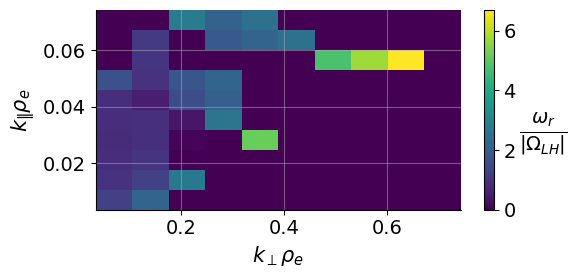

In [44]:
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.pcolormesh(k_perp_*alpha_c_perp, k_par_*alpha_c_perp, sol_.real * np.sqrt(mp_me))
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel(r'$\frac{\omega_{r}}{|\Omega_{LH}|}$', labelpad=20, rotation=0, fontsize=20)
ax.set_ylabel(r'$k_{\|}\rho_{e}$', fontsize=15)
ax.set_xlabel(r'$k_{\perp}\rho_{e}$', fontsize=15)
#ax.set_xticks([180, 200, 220, 240])
#ax.set_xlim(175, 245)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.5)
plt.tight_layout()
#plt.savefig("../../figs/vadim_2021/vadim_fig5_a.png", dpi=300, bbox_inches='tight')

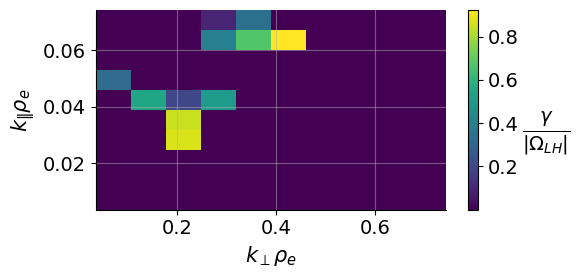

In [45]:
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.pcolormesh(k_perp_*alpha_c_perp, k_par_*alpha_c_perp, sol_.imag * np.sqrt(mp_me), vmin=1E-8)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel(r'$\frac{\gamma}{|\Omega_{LH}|}$', labelpad=20, rotation=0, fontsize=20)
ax.set_ylabel(r'$k_{\|}\rho_{e}$', fontsize=15)
ax.set_xlabel(r'$k_{\perp}\rho_{e}$', fontsize=15)
#ax.set_xticks([180, 200, 220, 240])
#ax.set_xlim(175, 245)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.5)
plt.tight_layout()
#plt.savefig("../../figs/vadim_2021/vadim_fig5_a.png", dpi=300, bbox_inches='tight')